In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import torch.nn.functional as F

pd.set_option('display.max_columns', None)

In [2]:
supervector_df_Standard = pd.read_csv(r'D:\Mémoire\Mémoire\Projet\ellipsometry\results\20250428_1434\supervector.csv')
print("Supervector DataFrame :")
supervector_df_Standard.head()

Supervector DataFrame :


,psi,delta,wavelength,thickness
0,29.226378,31.422612,300.0,0.0
1,28.979889,31.358813,301.0,0.0
2,28.755991,31.312190,302.0,0.0
3,28.546622,31.275586,303.0,0.0
4,28.348329,31.246076,304.0,0.0


In [3]:
supervector_df_Maxwell_Garnett = pd.read_csv(r'D:\Mémoire\Mémoire\Projet\ellipsometry\results\20250428_1444\supervector_maxwell_garnett.csv')
print("Supervector DataFrame :")
supervector_df_Maxwell_Garnett.head()

Supervector DataFrame :


,psi,delta,wavelength,thickness,vfraction
0,29.226378,31.422612,300.0,0.0,0.01
1,28.979889,31.358813,301.0,0.0,0.01
2,28.755991,31.312190,302.0,0.0,0.01
3,28.546622,31.275586,303.0,0.0,0.01
4,28.348329,31.246076,304.0,0.0,0.01


In [4]:
supervector_df_Lorentz = pd.read_csv(r'D:\Mémoire\Mémoire\Projet\ellipsometry\results\20250429_2344\supervector_lorentzian.csv')
print("Supervector DataFrame :")
supervector_df_Lorentz.head()

Supervector DataFrame :


,psi,delta,wavelength,thickness,lambda0,gamma,amplitude
0,29.226378,31.422612,300.0,0.0,438.240013,67.038748,0.251549
1,28.979889,31.358813,301.0,0.0,438.240013,67.038748,0.251549
2,28.755991,31.312190,302.0,0.0,438.240013,67.038748,0.251549
3,28.546622,31.275586,303.0,0.0,438.240013,67.038748,0.251549
4,28.348329,31.246076,304.0,0.0,438.240013,67.038748,0.251549


In [5]:
def group_and_flatten(df):
    # Déterminer les colonnes de groupement possibles
    possible_group_cols = ['vfraction', 'thickness', 'lambda0', 'gamma', 'amplitude']
    
    # Trouver les colonnes de groupement qui existent dans le dataframe
    group_cols = [col for col in possible_group_cols if col in df.columns]
    
    # Si aucune colonne de groupement n'est trouvée, on peut utiliser une colonne par défaut ou lever une exception
    if not group_cols:
        raise ValueError("Aucune colonne de groupement appropriée trouvée dans le dataframe")
    
    # Effectuer le groupby et le flatten
    grouped = df.groupby(group_cols)[['psi', 'delta']].apply(
        lambda x: x.values.flatten()
    ).reset_index()
    
    # Renommer la colonne résultante
    grouped.columns = list(group_cols) + ['psi_delta_flatten']
    
    return grouped

# Utilisation pour chaque dataset
grouped_standard = group_and_flatten(supervector_df_Standard)
grouped_maxwell = group_and_flatten(supervector_df_Maxwell_Garnett)
grouped_lorentz = group_and_flatten(supervector_df_Lorentz)


In [6]:
import numpy as np

def prepare_features_labels(grouped_df):
    """
    Prépare les matrices X (features) et y (labels) à partir d'un DataFrame groupé
    
    Args:
        grouped_df: DataFrame résultant de la fonction group_and_flatten
    
    Returns:
        X: matrice des features (valeurs de psi et delta flatten)
        y: matrice des labels (toutes les colonnes sauf 'psi_delta_flatten')
        feature_names: noms des colonnes utilisées comme labels
    """
    # Features (X) - toujours la colonne flatten
    X = np.stack(grouped_df['psi_delta_flatten'].values)
    
    # Labels (y) - toutes les colonnes sauf 'psi_delta_flatten'
    label_cols = [col for col in grouped_df.columns if col != 'psi_delta_flatten']
    y = grouped_df[label_cols].values
    
    print(f"Dimensions des entrées (X): {X.shape}")
    print(f"Dimensions des sorties (y): {y.shape}")
    print(f"Colonnes utilisées comme labels: {label_cols}")
    
    return X, y, label_cols

In [7]:
# Pour le dataset Standard
X_std, y_std, labels_std = prepare_features_labels(grouped_standard)

# Pour Maxwell-Garnett
X_mg, y_mg, labels_mg = prepare_features_labels(grouped_maxwell)

# Pour Lorentz
X_lor, y_lor, labels_lor = prepare_features_labels(grouped_lorentz)

Dimensions des entrées (X): (61, 1002)
Dimensions des sorties (y): (61, 1)
Colonnes utilisées comme labels: ['thickness']
Dimensions des entrées (X): (1830, 1002)
Dimensions des sorties (y): (1830, 2)
Colonnes utilisées comme labels: ['vfraction', 'thickness']
Dimensions des entrées (X): (1830, 1002)
Dimensions des sorties (y): (1830, 4)
Colonnes utilisées comme labels: ['thickness', 'lambda0', 'gamma', 'amplitude']


In [8]:
def prepare_and_split_data(grouped_df, test_size=0.2, random_state=42):
    """
    Prépare les données et les divise en gardant les relations entre les variables cibles
    
    Args:
        grouped_df: DataFrame après group_and_flatten
        test_size: proportion pour le test set
        random_state: seed aléatoire
    
    Returns:
        X_train, X_test, y_train, y_test (y conserve toutes les cibles)
        et la liste des noms des cibles
    """
    # Préparation des features et labels
    X = np.stack(grouped_df['psi_delta_flatten'].values)
    y = grouped_df.drop(columns=['psi_delta_flatten']).values
    label_names = grouped_df.drop(columns=['psi_delta_flatten']).columns.tolist()
    
    # Split en gardant toutes les cibles ensemble
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape} (labels: {label_names})")
    print(f"y_test shape: {y_test.shape}")
    
    return X_train, X_test, y_train, y_test, label_names

In [9]:
#Pour le dataset Standard (tous les paramètres ensemble)
X_train_std, X_test_std, y_train_std, y_test_std, labels_std = prepare_and_split_data(grouped_standard)

# Pour Maxwell-Garnett (vfraction + thickness ensemble)
X_train_mg, X_test_mg, y_train_mg, y_test_mg, labels_mg = prepare_and_split_data(grouped_maxwell)

# Pour Lorentz (tous les paramètres ensemble)
X_train_lor, X_test_lor, y_train_lor, y_test_lor, labels_lor = prepare_and_split_data(grouped_lorentz)

X_train shape: (48, 1002)
X_test shape: (13, 1002)
y_train shape: (48, 1) (labels: ['thickness'])
y_test shape: (13, 1)
X_train shape: (1464, 1002)
X_test shape: (366, 1002)
y_train shape: (1464, 2) (labels: ['vfraction', 'thickness'])
y_test shape: (366, 2)
X_train shape: (1464, 1002)
X_test shape: (366, 1002)
y_train shape: (1464, 4) (labels: ['thickness', 'lambda0', 'gamma', 'amplitude'])
y_test shape: (366, 4)


In [10]:
from sklearn.preprocessing import MinMaxScaler
import torch
import numpy as np

def preprocess_and_convert(X_train, X_test, y_train, y_test):
    """
    Applique uniquement une normalisation MinMax aux features et labels.

    Args:
        X_train, X_test: Données d'entrée (features) d'entraînement et de test
        y_train, y_test: Labels (sorties) d'entraînement et de test

    Returns:
        Dictionnaire contenant les tenseurs normalisés et les scalers MinMax
    """
    # Scaler MinMax pour les features
    scaler_X = MinMaxScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    # Scaler MinMax pour les labels
    scaler_y = MinMaxScaler()
    y_train_scaled = scaler_y.fit_transform(y_train)
    y_test_scaled = scaler_y.transform(y_test)

    # Conversion en tenseurs PyTorch
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

    return {
        'X_train': X_train_tensor,
        'X_test': X_test_tensor,
        'y_train': y_train_tensor,
        'y_test': y_test_tensor,
        'scaler_X': scaler_X,
        'scaler_y': scaler_y
    }

def inverse_transform_y(y_pred_tensor, scaler_y):
    """
    Inverse la normalisation MinMax des prédictions.

    Args:
        y_pred_tensor: Tenseur PyTorch des prédictions.
        scaler_y: Scaler MinMax utilisé pour normaliser y.

    Returns:
        Prédictions dans l'échelle d'origine (numpy array).
    """
    if scaler_y is None:
        return y_pred_tensor.numpy()
    
    y_pred_np = y_pred_tensor.detach().numpy()
    return scaler_y.inverse_transform(y_pred_np)


In [11]:
import torch.nn as nn
import torch.nn.functional as F

class FlexibleNN(nn.Module):
    """
    Réseau neuronal flexible simplifié avec:
    - Nombre de couches configurable
    - Activation paramétrable
    - Initialisation intelligente
    - Pas de BatchNorm
    """
    def __init__(self, input_dim, output_dim, 
                 hidden_dims=[256, 256, 256],
                 activation='leaky_relu',
                 dropout_rate=0.0):
        super(FlexibleNN, self).__init__()
        
        # Configuration des couches
        layers = []
        dims = [input_dim] + hidden_dims
        
        # Construction dynamique des couches cachées
        for i in range(len(dims)-1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            layers.append(self._get_activation(activation))
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))
        
        self.hidden_layers = nn.Sequential(*layers)
        self.output = nn.Linear(dims[-1], output_dim)
        
        # Initialisation des poids
        self._init_weights()
    
    def _init_weights(self):
        """Initialisation adaptative des poids"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                nn.init.constant_(m.bias, 0.1)
    
    def _get_activation(self, name):
        """Retourne la fonction d'activation"""
        return {
            'relu': nn.ReLU(),
            'leaky_relu': nn.LeakyReLU(0.1),
            'elu': nn.ELU(),
            'tanh': nn.Tanh(),
            'sigmoid': nn.Sigmoid(),
        }.get(name.lower(), nn.LeakyReLU(0.1))
    
    def forward(self, x):
        x = self.hidden_layers(x)
        return self.output(x)

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    """Bloc résiduel avec option dropout et activation paramétrable"""
    def __init__(self, dim, activation='leaky_relu', dropout_rate=0.0):
        super(ResidualBlock, self).__init__()
        
        self.linear1 = nn.Linear(dim, dim)
        self.linear2 = nn.Linear(dim, dim)
        self.activation = self._get_activation(activation)
        self.dropout = nn.Dropout(dropout_rate) if dropout_rate > 0 else nn.Identity()
        
        # Initialisation des poids
        self._init_weights()
    
    def _init_weights(self):
        nn.init.kaiming_uniform_(self.linear1.weight, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.constant_(self.linear1.bias, 0.1)
        nn.init.kaiming_uniform_(self.linear2.weight, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.constant_(self.linear2.bias, 0.1)
    
    def _get_activation(self, name):
        """Retourne la fonction d'activation"""
        return {
            'relu': nn.ReLU(),
            'leaky_relu': nn.LeakyReLU(0.1),
            'elu': nn.ELU(),
            'tanh': nn.Tanh(),
            'sigmoid': nn.Sigmoid(),
        }.get(name.lower(), nn.LeakyReLU(0.1))
    
    def forward(self, x):
        residual = x
        out = self.linear1(x)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.linear2(out)
        out += residual  # Connexion résiduelle
        return self.activation(out)

class FlexibleResNet(nn.Module):
    """
    ResNet flexible avec:
    - Nombre de blocs résiduels configurable
    - Activation paramétrable
    - Dropout optionnel
    - Initialisation intelligente
    """
    def __init__(self, input_dim, output_dim, 
                 hidden_dims=[256, 256, 256],
                 activation='leaky_relu',
                 dropout_rate=0.0):
        super(FlexibleResNet, self).__init__()
        
        # Couche d'entrée
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.input_activation = self._get_activation(activation)
        
        # Blocs résiduels
        self.residual_blocks = nn.ModuleList()
        for dim in hidden_dims:
            self.residual_blocks.append(
                ResidualBlock(dim, activation, dropout_rate)
            )
        
        # Couche de sortie
        self.output = nn.Linear(hidden_dims[-1], output_dim)
        
        # Initialisation des poids
        self._init_weights()
    
    def _init_weights(self):
        nn.init.kaiming_uniform_(self.input_layer.weight, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.constant_(self.input_layer.bias, 0.1)
        nn.init.xavier_uniform_(self.output.weight)
        nn.init.constant_(self.output.bias, 0.1)
    
    def _get_activation(self, name):
        """Retourne la fonction d'activation"""
        return {
            'relu': nn.ReLU(),
            'leaky_relu': nn.LeakyReLU(0.1),
            'elu': nn.ELU(),
            'tanh': nn.Tanh(),
            'sigmoid': nn.Sigmoid(),
        }.get(name.lower(), nn.LeakyReLU(0.1))
    
    def forward(self, x):
        x = self.input_layer(x)
        x = self.input_activation(x)
        
        for block in self.residual_blocks:
            x = block(x)
        
        return self.output(x)

In [15]:
# Courbes de loss
def plot_losses(train_loss, test_loss, title):
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(test_loss, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Courbes de Loss - {title}')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_predictions(model, X_test, y_test, scaler_y, label_names, title):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
    
    # Vérifiez si les dimensions correspondent
    if y_pred.shape[1] != y_test.shape[1]:
        print(f"Erreur : Les dimensions des prédictions ({y_pred.shape[1]}) ne correspondent pas aux labels ({y_test.shape[1]}).")
        return
    
    # Conversion inverse des données normalisées
    y_test_orig = inverse_transform_y(y_test, scaler_y)
    y_pred_orig = inverse_transform_y(y_pred, scaler_y)
    
    # Création des graphiques pour chaque paramètre
    n_params = y_test.shape[1]
    plt.figure(figsize=(15, 3 * n_params))
    
    for i in range(n_params):
        plt.subplot(1, n_params, i + 1)
        plt.scatter(y_test_orig[:, i], y_pred_orig[:, i], alpha=0.5)
        plt.plot([y_test_orig[:, i].min(), y_test_orig[:, i].max()],
                 [y_test_orig[:, i].min(), y_test_orig[:, i].max()], 'r--')
        plt.xlabel('Valeur réelle')
        plt.ylabel('Valeur prédite')
        plt.title(f'{title} - {label_names[i]}')
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

Residual vs Vanilla


=== Processing Standard Dataset ===

Training FlexibleNN...

Training FlexibleResNet...

=== Training Times ===
FlexibleNN: 0.92 seconds
FlexibleResNet: 0.80 seconds

Plotting losses for FlexibleNN...


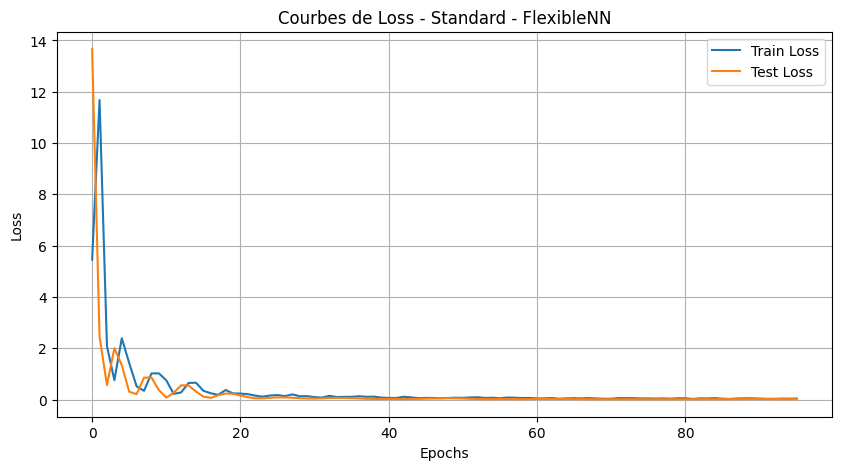

Plotting predictions for FlexibleNN...


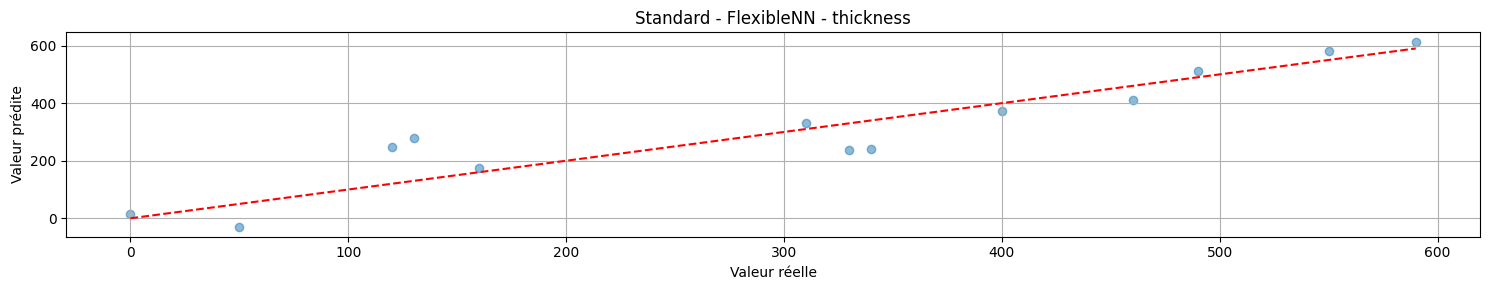


Plotting losses for FlexibleResNet...


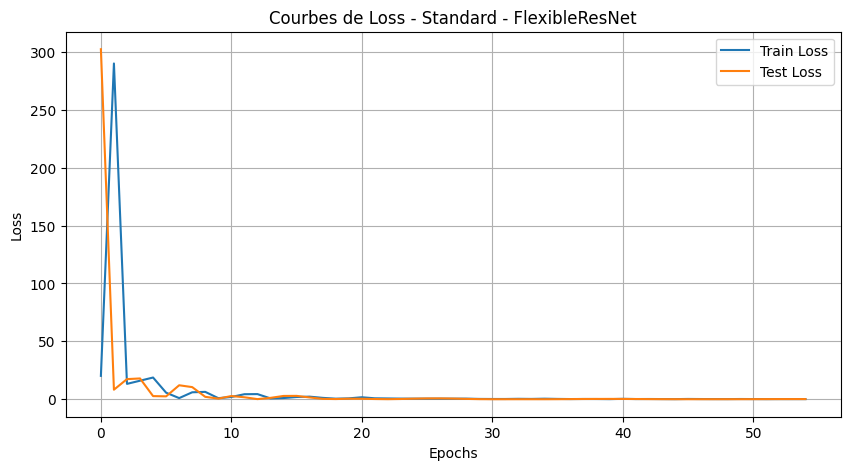

Plotting predictions for FlexibleResNet...


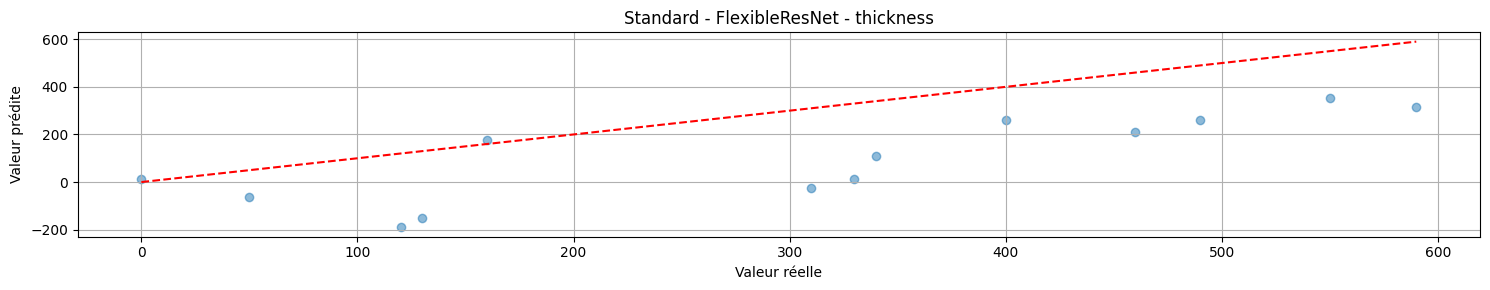


=== Final Results ===
FlexibleNN:
  - Final Train Loss: 0.0394
  - Final Test Loss: 0.0155
  - Training Time: 0.92s
  - Epochs: 96
FlexibleResNet:
  - Final Train Loss: 0.1410
  - Final Test Loss: 0.1563
  - Training Time: 0.80s
  - Epochs: 55

=== Processing Maxwell-Garnett Dataset ===

Training FlexibleNN...

Training FlexibleResNet...

=== Training Times ===
FlexibleNN: 19.49 seconds
FlexibleResNet: 42.38 seconds

Plotting losses for FlexibleNN...


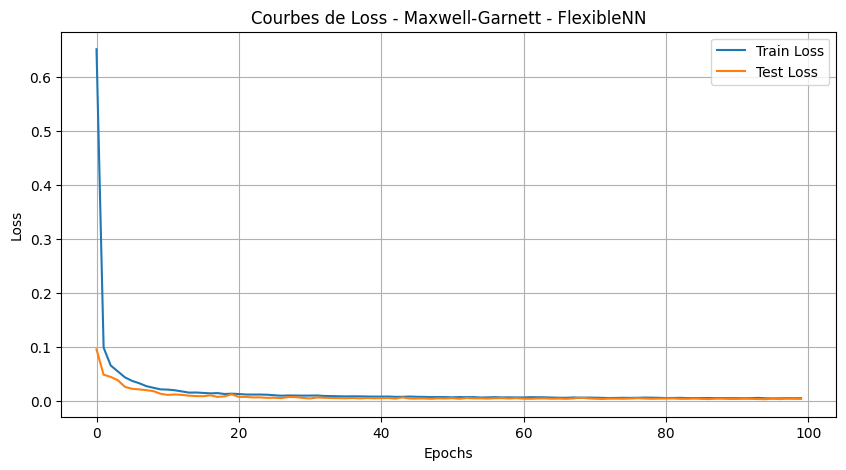

Plotting predictions for FlexibleNN...


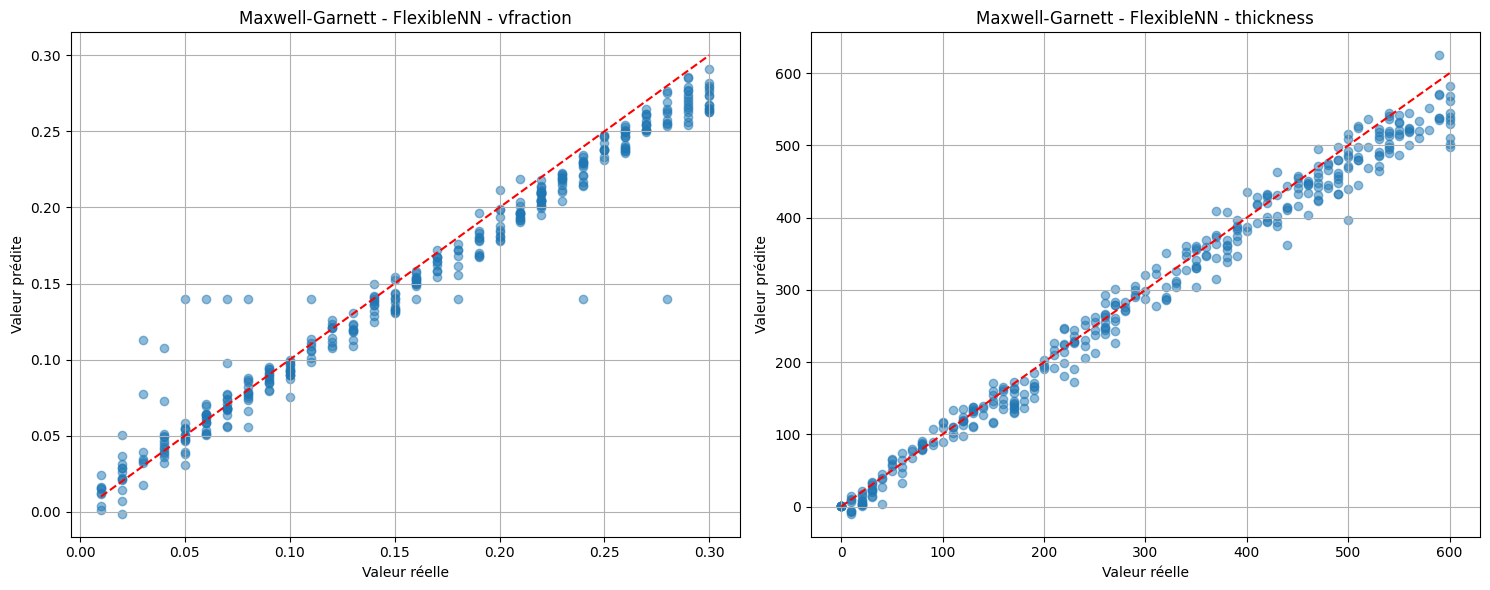


Plotting losses for FlexibleResNet...


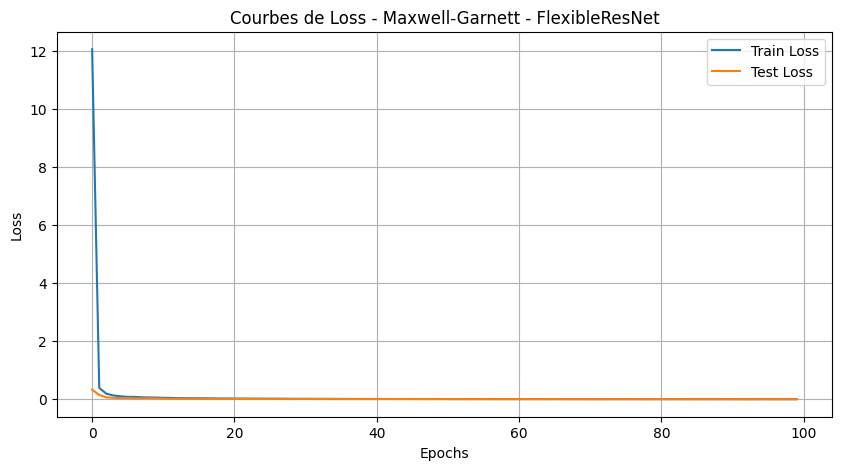

Plotting predictions for FlexibleResNet...


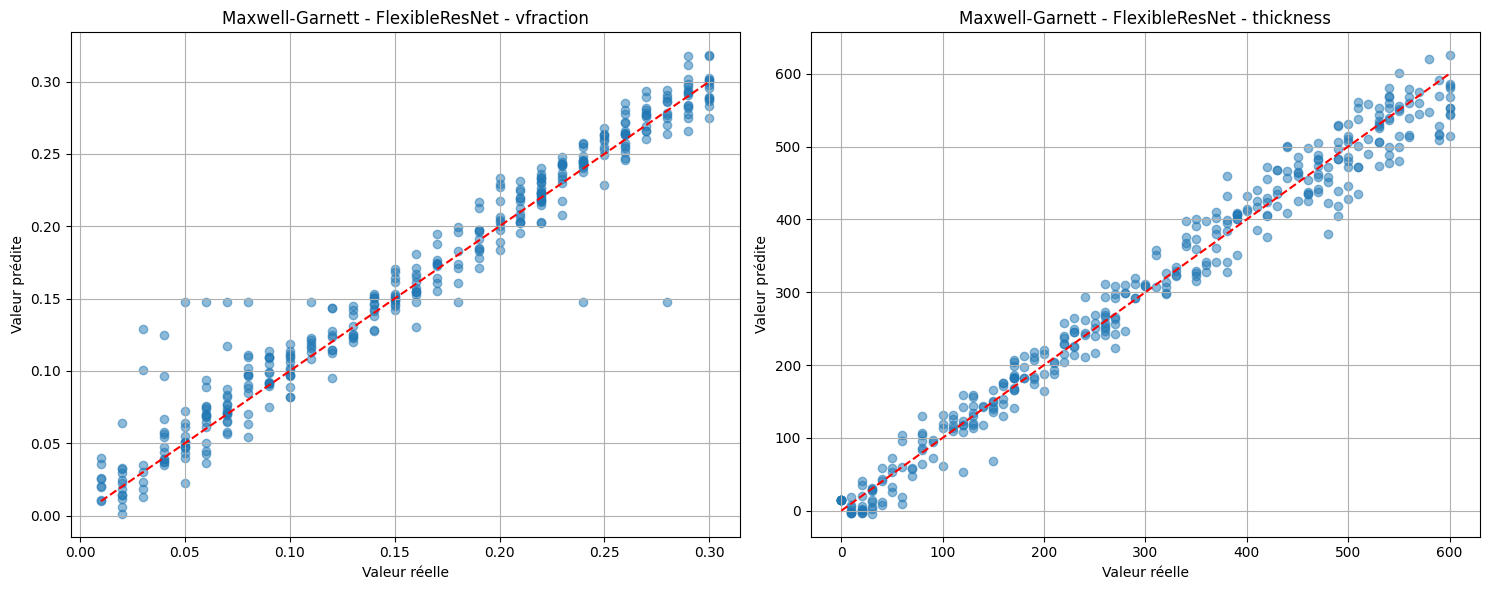


=== Final Results ===
FlexibleNN:
  - Final Train Loss: 0.0043
  - Final Test Loss: 0.0032
  - Training Time: 19.49s
  - Epochs: 100
FlexibleResNet:
  - Final Train Loss: 0.0048
  - Final Test Loss: 0.0034
  - Training Time: 42.38s
  - Epochs: 100

=== Processing Lorentz Dataset ===

Training FlexibleNN...

Training FlexibleResNet...

=== Training Times ===
FlexibleNN: 21.87 seconds
FlexibleResNet: 38.39 seconds

Plotting losses for FlexibleNN...


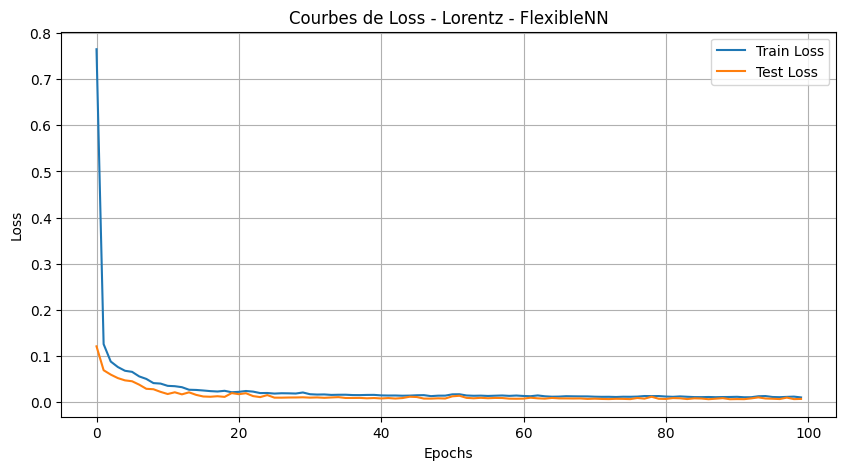

Plotting predictions for FlexibleNN...


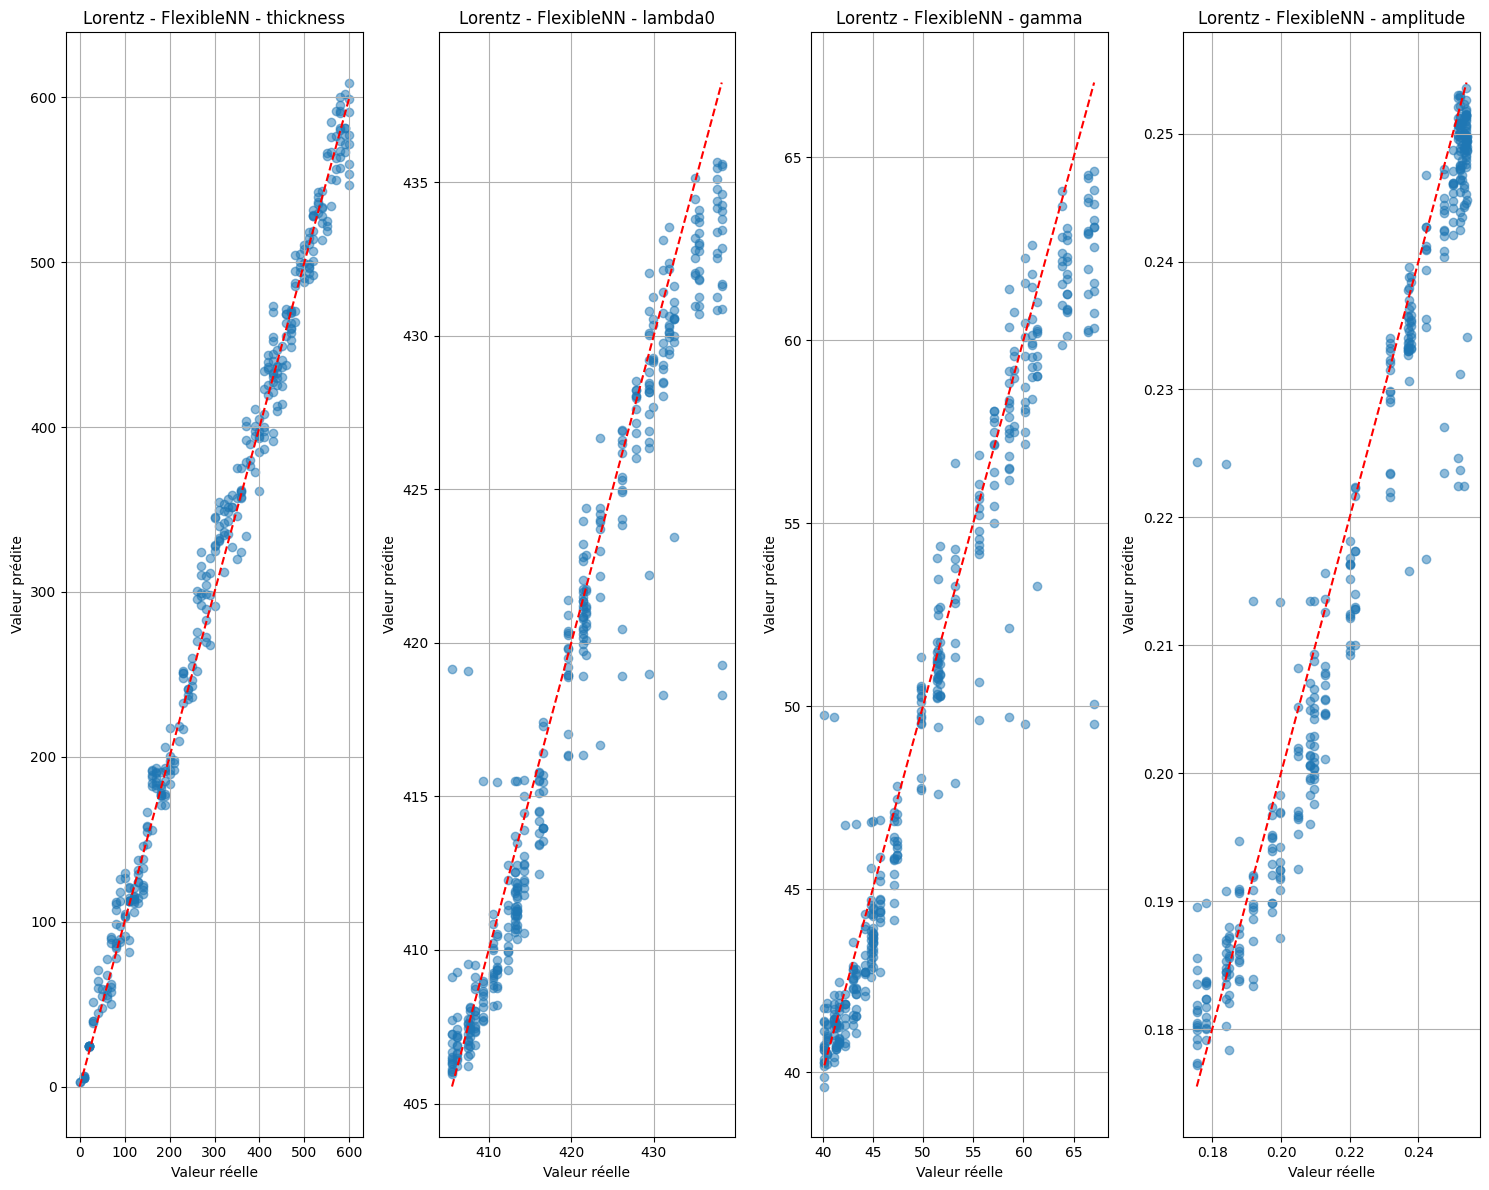


Plotting losses for FlexibleResNet...


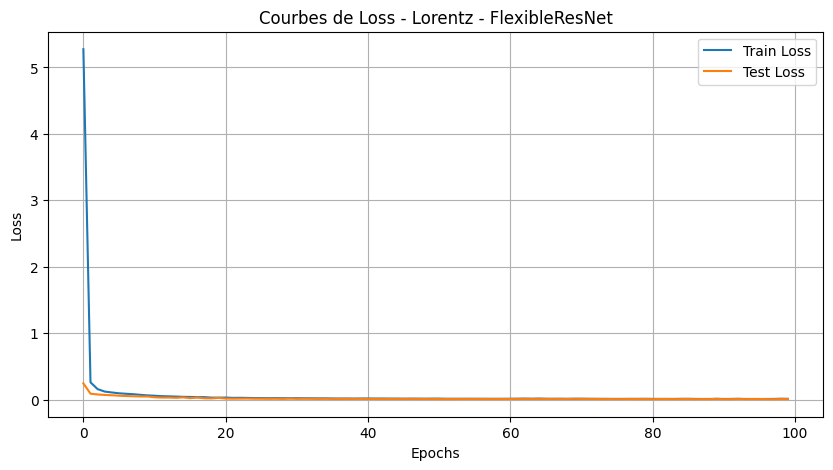

Plotting predictions for FlexibleResNet...


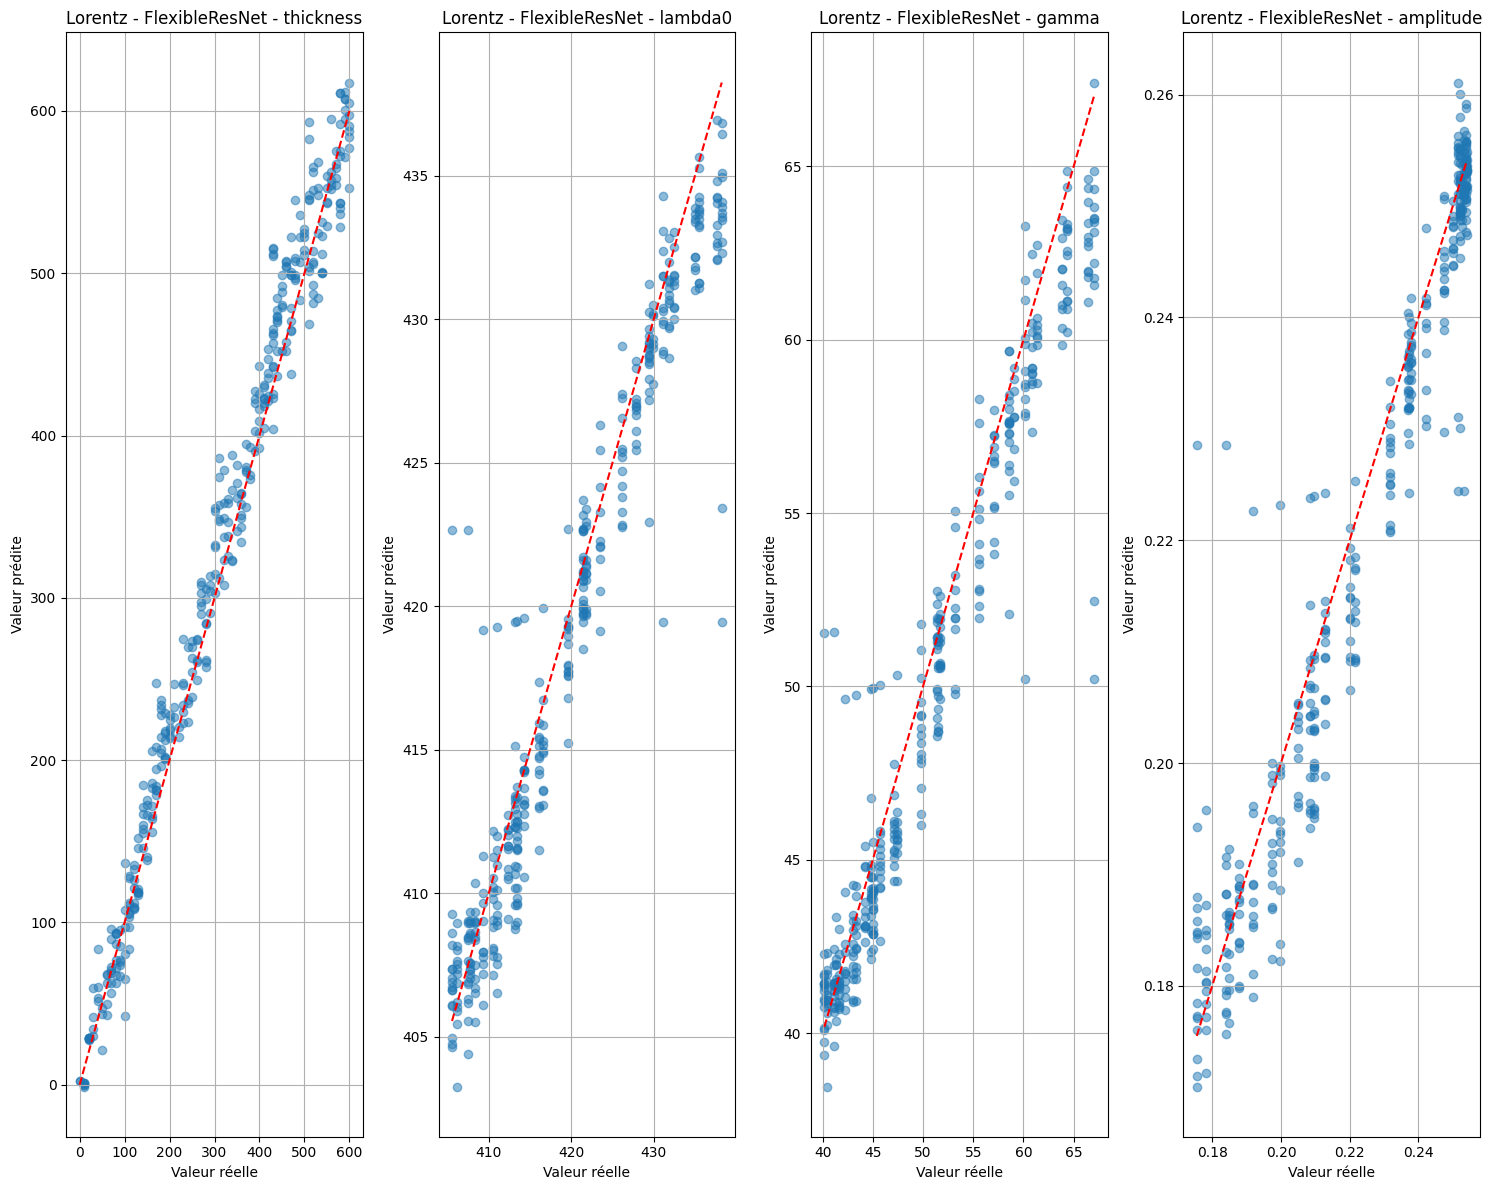


=== Final Results ===
FlexibleNN:
  - Final Train Loss: 0.0096
  - Final Test Loss: 0.0064
  - Training Time: 21.87s
  - Epochs: 100
FlexibleResNet:
  - Final Train Loss: 0.0108
  - Final Test Loss: 0.0067
  - Training Time: 38.39s
  - Epochs: 100


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import time

# Configuration de base
BASE_CONFIG = {
    'batch_size': 64,
    'learning_rate': 0.001,
    'weight_decay': 1e-5,
    'epochs': 100,
    'patience': 20,
    'hidden_dims': [256, 256, 256],
    'activation': 'leaky_relu',
    'dropout_rate': 0.1
}

# Fonction pour entraîner et évaluer un modèle
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, epochs, patience):
    train_losses = []
    test_losses = []
    best_loss = float('inf')
    best_epoch = 0
    best_model = None
    
    for epoch in range(epochs):
        # Training
        model.train()
        epoch_train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        train_losses.append(epoch_train_loss / len(train_loader))
        
        # Evaluation
        model.eval()
        epoch_test_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                epoch_test_loss += loss.item()
        test_loss = epoch_test_loss / len(test_loader)
        test_losses.append(test_loss)
        
        # Early stopping
        if test_loss < best_loss:
            best_loss = test_loss
            best_epoch = epoch
            best_model = model.state_dict()
        elif epoch - best_epoch >= patience:
            break
    
    # Restore best model
    model.load_state_dict(best_model)
    return model, train_losses, test_losses


# Chargement des datasets (à remplacer par vos données réelles)
datasets = {
    'Standard': {
        'X_train': X_train_std,
        'X_test': X_test_std,
        'y_train': y_train_std,
        'y_test': y_test_std,
        'param_names': labels_std
    },
    'Maxwell-Garnett': {
        'X_train': X_train_mg,
        'X_test': X_test_mg,
        'y_train': y_train_mg,
        'y_test': y_test_mg,
        'param_names': labels_mg
    },
    'Lorentz': {
        'X_train': X_train_lor,
        'X_test': X_test_lor,
        'y_train': y_train_lor,
        'y_test': y_test_lor,
        'param_names': labels_lor
    }
}

# Comparaison pour chaque dataset
# Comparaison pour chaque dataset
for name, data in datasets.items():
    print(f"\n=== Processing {name} Dataset ===")
    
    # Correct unpacking of the dictionary returned by preprocess_and_convert
    preprocessed_data = preprocess_and_convert(
        data['X_train'], data['X_test'], 
        data['y_train'], data['y_test']
    )

    train_loader = DataLoader(TensorDataset(preprocessed_data['X_train'], preprocessed_data['y_train']), 
                            batch_size=BASE_CONFIG['batch_size'], shuffle=True)
    test_loader = DataLoader(TensorDataset(preprocessed_data['X_test'], preprocessed_data['y_test']), 
                           batch_size=BASE_CONFIG['batch_size'], shuffle=False)
    y_scaler = preprocessed_data['scaler_y']
    
    # Initialisation des modèles
    input_dim = data['X_train'].shape[1]
    output_dim = data['y_train'].shape[1]
    
    models = {
        'FlexibleNN': FlexibleNN(
            input_dim, output_dim, 
            BASE_CONFIG['hidden_dims'], 
            BASE_CONFIG['activation'], 
            BASE_CONFIG['dropout_rate']
        ),
        'FlexibleResNet': FlexibleResNet(
            input_dim, output_dim, 
            BASE_CONFIG['hidden_dims'], 
            BASE_CONFIG['activation'], 
            BASE_CONFIG['dropout_rate']
        )
    }
    
    # Entraînement et évaluation
    results = {}
    training_times = {}  # Pour stocker les temps d'entraînement
    
    for model_name, model in models.items():
        print(f"\nTraining {model_name}...")
        optimizer = optim.AdamW(
            model.parameters(), 
            lr=BASE_CONFIG['learning_rate'], 
            weight_decay=BASE_CONFIG['weight_decay']
        )
        criterion = nn.MSELoss()
        
        # Mesure du temps d'entraînement
        start_time = time.time()
        trained_model, train_losses, test_losses = train_and_evaluate(
            model, train_loader, test_loader,
            criterion, optimizer,
            BASE_CONFIG['epochs'], BASE_CONFIG['patience']
        )
        training_time = time.time() - start_time
        training_times[model_name] = training_time
        
        results[model_name] = {
            'model': trained_model,
            'train_losses': train_losses,
            'test_losses': test_losses,
            'training_time': training_time
        }
    
    # Affichage des temps d'entraînement
    print("\n=== Training Times ===")
    for model_name, time_taken in training_times.items():
        print(f"{model_name}: {time_taken:.2f} seconds")
    
    # Visualisation des résultats
    for model_name, res in results.items():
        print(f"\nPlotting losses for {model_name}...")
        plot_losses(res['train_losses'], res['test_losses'], f"{name} - {model_name}")
        
        # Visualisation des prédictions
        print(f"Plotting predictions for {model_name}...")
        plot_predictions(
            res['model'],
            preprocessed_data['X_test'],
            preprocessed_data['y_test'],
            y_scaler,
            data['param_names'],
            f"{name} - {model_name}"
        )
    
    # Affichage des résultats finaux
    print("\n=== Final Results ===")
    for model_name, res in results.items():
        print(f"{model_name}:")
        print(f"  - Final Train Loss: {res['train_losses'][-1]:.4f}")
        print(f"  - Final Test Loss: {res['test_losses'][-1]:.4f}")
        print(f"  - Training Time: {res['training_time']:.2f}s")
        print(f"  - Epochs: {len(res['train_losses'])}")